# Bootstrapping

In [1]:
# import libraries 
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16}) 
import scipy.stats as stats
import scipy.optimize as opt
import savingfigR as sf

## Population Parameter Estimates

In [2]:
X = np.array([66, 79, 93, 86, 69, 79, 101, 97, 91, 95, 72, 106, 105, 75, 70, 85, 92, 74, 88, 93] )
Xm = np.mean(X) # compute a statistic of interest
print(Xm)

85.8


In [3]:
boot_m = 1000000 # how many simulated experiments?
Xm_boot = np.empty(boot_m) # create a list to store our bootstrap values
for i in range(0, boot_m): 
    Xb = np.random.choice(X, len(X), replace=True) # generate new sample
    Xm_boot[i] = np.mean(Xb) # compute statistic of interest

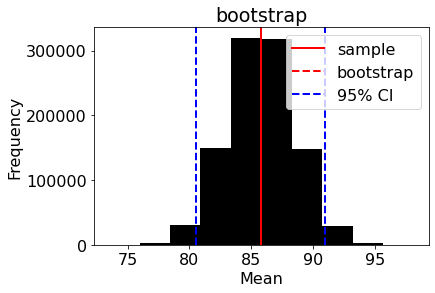

In [4]:
fig = plt.figure()
plt.hist(Xm_boot, color='k')
plt.axvline(np.mean(Xm), c='r', lw=2, label='sample')
plt.axvline(np.mean(Xm_boot), c='r', ls='--', lw=2, label='bootstrap')
ci95 = np.percentile(Xm_boot, (2.5, 97.5))
plt.axvline(ci95[0], c='b', lw=2, ls='--', label='95% CI')
plt.axvline(ci95[1], c='b', lw=2, ls='--')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.legend(loc=0)
plt.title('bootstrap')
plt.show()

sf.best_save(fig, 'pop_param_est')

## Hypothesis Testing - Two Sample

In [5]:
g_control = np.array([87,90,82,77,71,81,77,79,84,86,78,84,86,69,81,75,70,76,75,93])
g_drug = np.array([74,67,81,61,64,75,81,81,81,67,72,78,83,85,56,78,77,80,79,74])
# our statistic of interest here is the difference between means
abs_stat_obs = np.abs(np.mean(g_control) - np.mean(g_drug)) # good practice to take absolute value as to not mess up logical indexing 
print(abs_stat_obs)

5.349999999999994


In [6]:
n_perm = 10000 # how many simulated experiments?
stat_perm = np.empty(n_perm) # create a list to store our permutation test values
g_control_n = len(g_control)
g_drug_n = len(g_drug)
g_bucket = np.concatenate((g_control, g_drug))
g_bucket_n = len(g_bucket)
for i in range(n_perm): 
    # reconstitute both groups, ignoring original labels
    permuted_bucket = np.random.choice(g_bucket,g_bucket_n,replace=False)
    perm_control = permuted_bucket[0:g_control_n]
    perm_drug = permuted_bucket[(g_control_n):(g_control_n+g_drug_n)]
    stat_perm[i] = np.mean(perm_control) - np.mean(perm_drug)

pval = (np.sum(stat_perm <= -abs_stat_obs) + np.sum(stat_perm >= abs_stat_obs)) / n_perm # logical indexing 

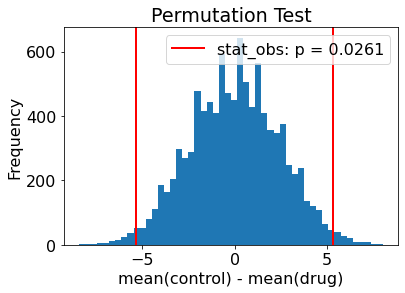

In [7]:
fig = plt.figure()
plt.hist(stat_perm, 50)
plt.axvline(abs_stat_obs, c='r', lw=2, label=f'stat_obs: p = {pval:.4f}')
plt.axvline(-abs_stat_obs, c='r', lw=2)
plt.xlabel('mean(control) - mean(drug)')
plt.ylabel('Frequency')
plt.title('Permutation Test')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'hyptest_2samp')

## Power Calculations 

In [8]:
g_control = np.array([87,90,82,87,71,81,77,79,84,86,78,84,86,69,81,75,70,76,75,93])
g_drug = np.array([74,73,81,65,64,72,76,81,81,67,72,78,83,75,66,78,77,80,79,74])
p_obs = stats.wilcoxon(g_control, g_drug, alternative="two-sided", mode='exact')[1]
n_boot = 10000
p_boot = np.empty(n_boot)
for i in range(n_boot): 
    b_control = np.random.choice(g_control,len(g_control),replace=True)
    b_drug = np.random.choice(g_drug,len(g_drug),replace=True)
    p_boot[i] = stats.wilcoxon(b_control, b_drug, alternative="two-sided", mode='exact')[1]

power = np.sum(p_boot <= .05) / n_boot
print(power)

/Users/duncan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


0.7696


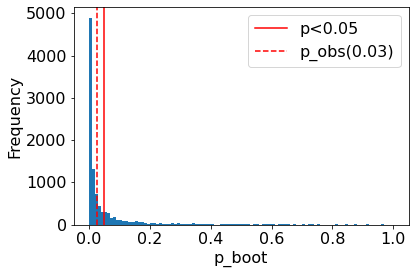

In [9]:
fig = plt.figure()
plt.hist(p_boot, bins=100)
plt.axvline(0.05, c='r', label='p<0.05')
plt.axvline(p_obs, c='r', ls='--', label=f'p_obs({p_obs:.2f})')
plt.legend(loc=0)
plt.xlabel('p_boot')
plt.ylabel('Frequency')
plt.show()

sf.best_save(fig, 'power_calc')

## Model Fitting - Data

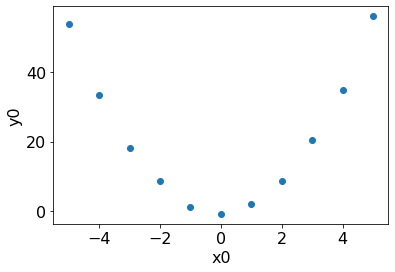

In [10]:
x0 = np.arange(-5,6,1)
## Can use commented out code to generate data
#noise = rnorm(11,0,1.0)
#c = 2.2 # pretend you don't know what the constant is (we are going to estimate this)
#y0 = c * x0^2 + noise
#y0
y0 = np.array([54.000534, 33.485031, 18.217317, 8.599760, 1.018073, -0.903174, 2.019343, 8.475278, 20.347628, 34.768279, 56.204352])

fig = plt.figure()
plt.scatter(x0, y0)
plt.xlabel('x0')
plt.ylabel('y0')
plt.show()

sf.best_save(fig, 'mf_data')

## Model Fitting - Loss Function

In [11]:
# This is our sum of least squares loss function
#C = initial guess on c, X = xvals, Y = yvals
def lse(C,X,Y): 
    c = C[0]
    x0 = X
    y0 = Y
    mindiff = np.sum((y0 - (c*x0**2))**2) # sum of least squares
    return mindiff

In [12]:
c_init = 5 # initial guess of the constant, c
params_LSE = opt.fmin(lambda x: lse(x, x0, y0), c_init)
print(params_LSE)

Optimization terminated successfully.
         Current function value: 9.871492
         Iterations: 18
         Function evaluations: 36
[2.17852783]


## Model Fitting - Bootstrapping

In [13]:
boot_m = 10000 # how many simulated experiments?
C_boot = np.empty(boot_m) # create a list to store our bootstrap values
X = np.empty(len(x0))
Y = np.empty(len(y0))
for i in range(boot_m): 
    for j in range(len(x0)): # inner loop used to preserve x,y pairs
        k = np.random.choice(len(x0), 1) # sample random integer
        X[j] = x0[k] # use integer to sample x,y pair
        Y[j] = y0[k]

    C_boot[i] = opt.fmin(lambda x: lse(x, X, Y), c_init, disp=0) # make sure disp=0 . it will stop the output and make sure your IDE doesn't crash 

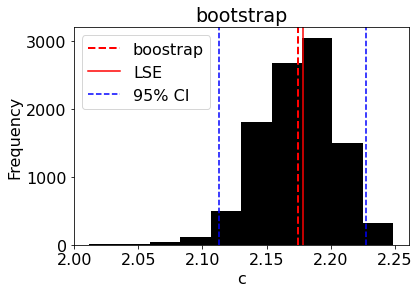

In [14]:
fig = plt.figure()
plt.hist(C_boot, color='k')
plt.axvline(np.mean(C_boot), c='r', lw=2, ls='--', label='boostrap')
plt.axvline(params_LSE, c='r', label='LSE')
ci95 = np.percentile(C_boot, (2.5, 97.5))
plt.axvline(ci95[0], c='b', ls='--', label='95% CI')
plt.axvline(ci95[1], c='b', ls='--')
plt.xlabel('c')
plt.ylabel('Frequency')
plt.title('bootstrap')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'mf_bootstrapping')

## Plotting Model Fits

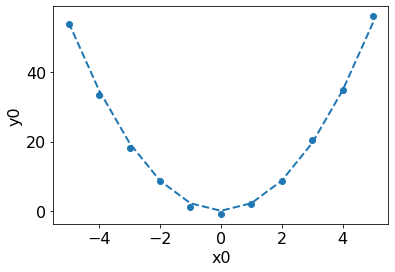

In [15]:
yfit = np.mean(C_boot)*x0**2

fig = plt.figure()
plt.scatter(x0, y0)
plt.plot(x0, yfit, lw=2, ls='--')
plt.xlabel('x0')
plt.ylabel('y0')
plt.show()

sf.best_save(fig, 'plotmodelfit')